# DANA 4830 team project

This notebook contains the code to perform Exploratory Factor Analysis, Clustering and Bootstrap methods for comparisson between the 2014 & 2020 [Australian Public Service census](https://data.gov.au/data/organization/australianpublicservicecommission)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as st

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import imread

from sklearn import metrics

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline

import os
import scipy.io

In [2]:
# fig configurations
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = [10,4]
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams.update({'legend.fontsize': 15})
plt.rcParams.update({'axes.labelsize': 20})
plt.rcParams.update({'font.size': 20})

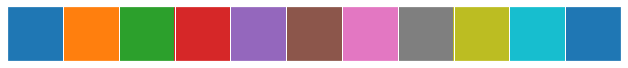

In [3]:
cpalette = sns.color_palette('tab10', 11)
sns.palplot(cpalette)

In [4]:
# savefig
def savePNG(f):
    if not os.path.isdir("figures"):
        os.makedirs("figures")
    fName = f+".png"
    fPath = os.path.join("figures",fName)
    plt.savefig(fPath, dpi=300)
    
# save df as csv
def saveCSV(f,fName):
    if not os.path.isdir("data"):
        os.makedirs("data")
    fName2 = fName+".csv"
    fPath = os.path.join("data",fName2)
    f.to_csv(fPath)

# 2020 data

Load the cleaned 2020 dataset. The master cleaned dataset for 2020 can be obtained from running the `dana30-masterDataset.py` script. 

In [5]:
if os.path.isdir("data"):
    d20 = pd.read_csv(os.path.join("data", "d20Master.csv"), index_col=0)
    d14 = pd.read_csv(os.path.join("data", "d14Master.csv"), index_col=0)
else:
    d20 = pd.read_csv(os.path.join("d20Master.csv"), index_col=0)
    d14 = pd.read_csv(os.path.join("d14Master.csv"), index_col=0)

In [6]:
d20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108085 entries, 0 to 108084
Columns: 213 entries, AS to q64.13
dtypes: float64(213)
memory usage: 176.5 MB


## 2014  data
Load the cleaned 2014 dataset. The master cleaned dataset for 2014 can be obtained from running the `dana30-2014masterDataset.py` script. 

In [7]:
d14.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99392 entries, 0 to 99391
Columns: 208 entries, AS to q81g.1
dtypes: float64(208)
memory usage: 158.5 MB


# 2. Exploratory Factor Analysis

Both datasets contain lots of column features. The present work aims to extract proxies for leadership, thus a selection of question based on leadership literature is made. In addition, to be able to extract the patterns embedded in Likert scale questions we perform an Exploratoriy Factor Analysis (EFA). The goal of EFA is to reduce the dimensionality of the feature space by re-scaling and rotating the axis of the coordinate system in which the features lie. As opposed to other dimensionality reduction techniques like Principal Component Analysis (PCA) that rotate their axis based on maximizing the variance explained without any information of the behavior of the features, EFA actually computes its axis based on maximizing shared variance among the features. Therefore, it allows to find a reduced coordinate system called **Factors** $\bf F$, which are unobserved variables that capture the largest amount of variability among some features. The magnitude of how much a Factor can describe the initial features is determined by the **Loadings** $\bf L$, which define a linear combination of loads onto latent factors. The equation in Matrix notation is 

\begin{align}
    \bf Z = X - \mu = L F + \epsilon
\end{align}

where the new data $\bf Z$ exists in EFA space, $\bf mu$ are the row means of $\bf X$,  $\bf L F$ is the linear combination of loadings in terms of unobserved latent factors and $\epsilon$ is the error matrix.

In [8]:
def split_sets(x, trainP=0.2, rs=42, stratified=False):
    testP = 1-trainP
    train_set, test_set = train_test_split(x, test_size=trainP, random_state=rs)
    return train_set, test_set

In [9]:
## alphabety
alphabet = list(map(chr, range(97, 123)))

In [10]:
def rm_cols(x, drp):
    """ Remove columns that are not considered for the EFA """
    
    drop_cols = []
    drp.append("nada")
    tick = [x.keys()[0], x.keys()[1], x.keys()[2], x.keys()[3]]
    tick_ix = [0, 1, 2, 3]

    for j in range(4, x.shape[1]):
        if x.keys()[j-1][:3] != x.keys()[j][:3]:
            tick.append(x.keys()[j])
            tick_ix.append(j)
    
    ix = dict(zip(tick, tick_ix))
    for k in range(len(drp)-1):
        i0 = ix[drp[k]]
        i1 = tick_ix[tick_ix.index(i0)+1]
        drop_cols += list(x[list(x.keys()[i0:i1].values)].keys())
        
    if ("q64.1" in drp) & ("q64.1" not in drop_cols):
        drop_cols += ["q64."+str(i) for i in range(1,14)]
        rm_ix = drp.index("q64.1")
        drp.pop(rm_ix)
        
    if ("q77" in drp) & ("q77" not in drop_cols):
        drop_cols += ["q77"]

    if ("q81a.1" in drp) & ("q81a.1" not in drop_cols):
        drop_cols += ["q81"+str(c)+".1" for c in list(map(chr, range(97, 104)))]

   
    return drop_cols

In [11]:
## sub 2 : is the best cjoice for clustering Leadership styles in 2020
sub1 = rm_cols(d14, ["q19a", "q21a"])
sub2 = rm_cols(d20, ["q19a", "q21a"]) + ["q48e", "q47c"]

## compute new sets
X1 = d14[sub1]
X2 = d20[sub2] 

In [12]:
class ExpFacAn:
    """ 
    Define Exploratory Factor Analysis class object
    this includes Eigenvalues, loadings and Factor 
    Analysis suitability tests
    """

    def __init__(self, X, nFactors=5, rot=None):
        fa = FactorAnalyzer(n_factors=nFactors, rotation=rot)
        fa.fit(X)
        eigVal, Val = fa.get_eigenvalues()
        
        self.Fit = fa.fit(X)
        self.Eig = eigVal
        self.Val = Val
        
        '''
        Barlett specificity
        '''
        chi_square_value,p_value = calculate_bartlett_sphericity(X1)
        self.Barlett = (chi_square_value, p_value)

        '''
        Kaiser-Meyer_Olkin
        '''
        kmo_all, kmo_model = calculate_kmo(X1)
        self.KMO = kmo_model

        EFAloadings = pd.DataFrame(fa.loadings_, columns=["Factor "+str(i+1) for i in range(nFactors)])
        EFAloadings["q"] = list(X.keys())
        EFAloadings = EFAloadings.set_index("q")
        
        self.loadings = EFAloadings

In [13]:
## sub 2 : is the best cjoice for clustering Leadership styles in 2020
sub1 = rm_cols(d14, ["q20a", "q21a"]) + ["q18b"]
sub2 = rm_cols(d20, ["q19a", "q21a"]) + ["q48e", "q47c"]

## compute new sets
X1 = d14[sub1]
X2 = d20[sub2] 

In [14]:
## EFA for X1 (2014)
efaX1 = ExpFacAn(X1, rot="varimax")

## EFA for X2 (2020)
efaX2 = ExpFacAn(X2, rot="varimax")

# pprint
print("% explained: ", np.cumsum(efaX2.Eig[:2])[-1]/sum(efaX2.Eig))

/home/igodlab/anaconda3/envs/pytorch-env/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


% explained:  0.7794936980725443


/home/igodlab/anaconda3/envs/pytorch-env/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


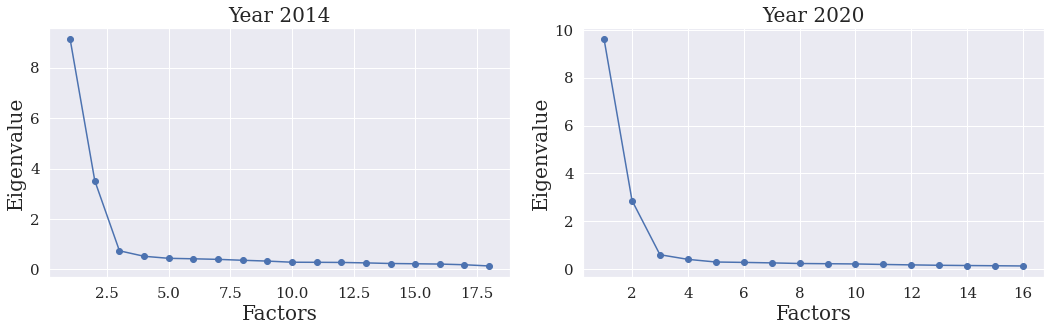

In [15]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

## plot
axes[0].scatter(range(1,X1.shape[1]+1),efaX1.Eig)
axes[0].plot(range(1,X1.shape[1]+1),efaX1.Eig)
axes[0].set_title('Year 2014', size=20)
axes[0].set_xlabel('Factors')
axes[0].set_ylabel('Eigenvalue')


## plot
axes[1].scatter(range(1,X2.shape[1]+1),efaX2.Eig)
axes[1].plot(range(1,X2.shape[1]+1),efaX2.Eig)
axes[1].set_title('Year 2020', size=20)
axes[1].set_xlabel('Factors')
axes[1].set_ylabel('Eigenvalue')

plt.tight_layout()
#savePNG("scree-plots")

Figure 1. Scree plot of the eigenvalues per year. In both years we can see that it is sufficient for two factors to explain most of th evariability of the data. Thu, only two factors are considered for further EFA tests.

# Clustering analysis

We have computed the new set of data $\bf Z$ that lives in the EFA space. Moreover, given the low dimensionality of the Factors we can visually observe the geometrical representation of the clusters that the questions form in the 2D plot for the Factors (identified as as representing leadership styles). 

To further confirm this finding we can now make use of the **k-Means** algortihm to group the datapoints $\bf Z$ into clusters. In our case, since we already know that the EFA resulted in suggesting to use two factors then that is a hint for selecting the number of cluster for our unsupervised classification algortihm. 

The main idea behind k-Means is to find labels to the datapoints by following three simple steps: i) randomly select $k=2$ points and then calculate the distance of each observation $\bf z_i$ to each $k$ means. ii) Label each datapoint as belonging to its nearest mean. iii) Find the center of mass for each labeled cluster. Then the new means are the previous center of mass and repeat.

In [16]:
from sklearn.cluster import KMeans

In [17]:
## function for metrics
def modelMetrics(model, X, Y):
    predict = model.predict(X)     ## predict outcomes using the test set
    probs   = model.predict_proba(X) ## generate class probabilities

    ## generate evaluation metrics
    jaccScore = metrics.accuracy_score(Y, predict)
    rocScore  = metrics.roc_auc_score(Y, probs[:, 1])

    conf_matrix = metrics.confusion_matrix(Y, predict)
    
    return {"jacc": jaccScore, "roc": rocScore, "confMat": conf_matrix}

In [18]:
#split
X1red = np.array(efaX1.loadings[["Factor 1", "Factor 2"]])
X2red = np.array(efaX2.loadings[["Factor 1", "Factor 2"]])

In [19]:
# k-Means algorithm
km = KMeans(n_clusters=2, random_state=42)

kmFit1 = km.fit_predict(X1red)
kmFit2 = km.fit_predict(X2red)

% 2014 explained:  0.7023070433554797
% 2020 explained:  0.7794936980725443


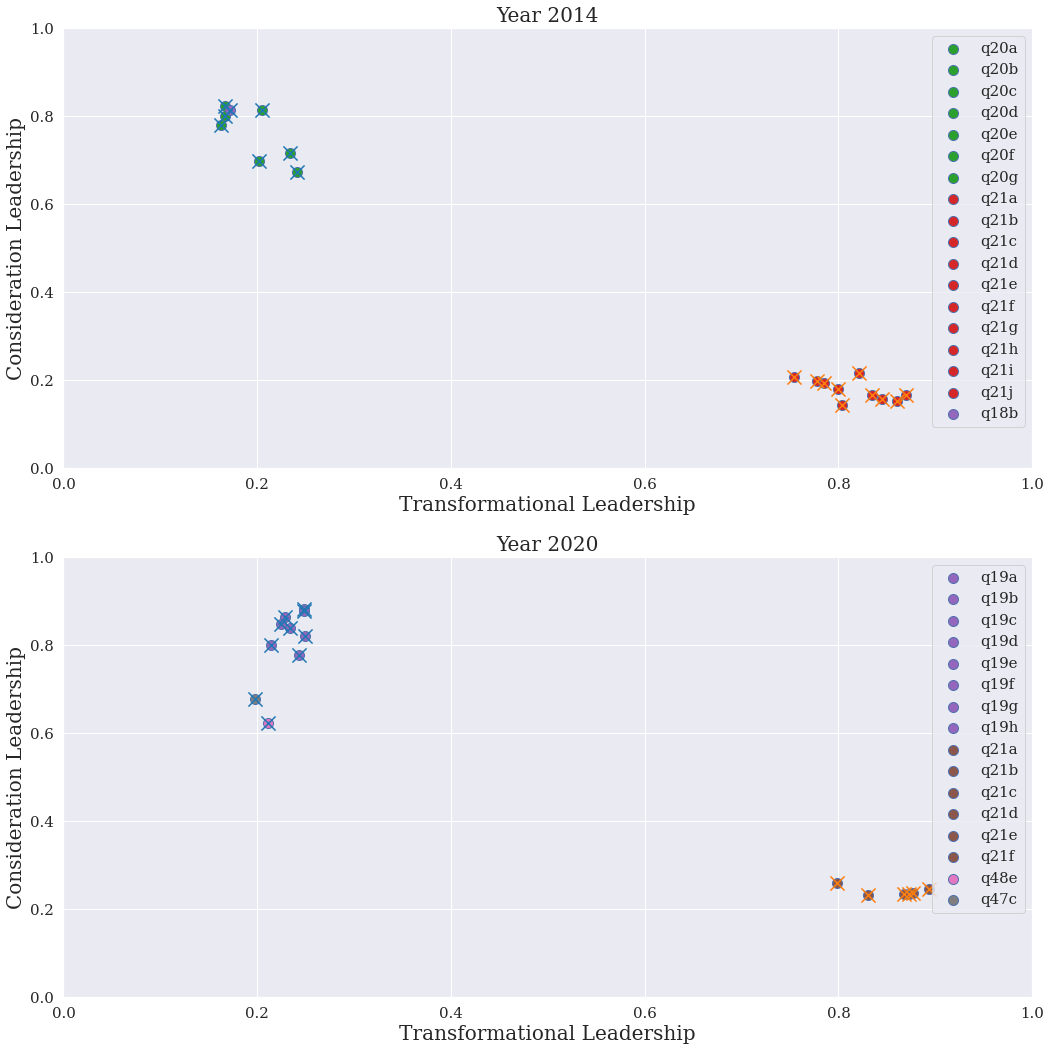

In [20]:
fig, axes = plt.subplots(2,1,figsize=(15,15))

ax_x = "Factor 1"
ax_y = "Factor 2"

color_i = 2

# 2014
# pprint
print("% 2014 explained: ", np.cumsum(efaX1.Eig[:2])[-1]/sum(efaX1.Eig))

axes[0].scatter(efaX1.loadings[ax_x][0],efaX1.loadings[ax_y][0], marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX1.loadings.index[0])
for i in range(1, efaX1.loadings.shape[0]):
    x = efaX1.loadings[ax_x][i]
    y = efaX1.loadings[ax_y][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX1.loadings.index[i-1][2] != efaX1.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes[0].scatter(x,y, marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX1.loadings.index[i])
    

for i in range(efaX1.loadings.shape[0]):
    x = efaX1.loadings[ax_x][i]
    y = efaX1.loadings[ax_y][i]
    
    if kmFit1[i] == 0:
        axes[0].scatter(x,y,marker='x', color=cpalette[0], s=200)
    else:
        axes[0].scatter(x,y,marker='x', color=cpalette[1], s=200)


# 2020

# pprint
color_i = 4
print("% 2020 explained: ", np.cumsum(efaX2.Eig[:2])[-1]/sum(efaX2.Eig))

axes[1].scatter(efaX2.loadings[ax_y][0],efaX2.loadings[ax_x][0], marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX2.loadings.index[0])
for i in range(1, efaX2.loadings.shape[0]):
    x = efaX2.loadings[ax_y][i]
    y = efaX2.loadings[ax_x][i]
    #z = efaX1.loadings["Factor 3"][i]
    color_i = (color_i % (len(cpalette)-1))
    if efaX2.loadings.index[i-1][2] != efaX2.loadings.index[i][2]:
        color_i += 1
    #color_i += 1
    axes[1].scatter(x,y, marker='o', color=cpalette[color_i], s=100, edgecolors='b', label=efaX2.loadings.index[i])
    

for i in range(efaX2.loadings.shape[0]):
    x = efaX2.loadings[ax_y][i]
    y = efaX2.loadings[ax_x][i]
    
    if kmFit2[i] == 0:
        axes[1].scatter(x,y,marker='x', color=cpalette[0], s=200)
    else:
        axes[1].scatter(x,y,marker='x', color=cpalette[1], s=200)
    

axes[0].set_xlabel("Transformational Leadership")
axes[0].set_ylabel("Consideration Leadership")
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
axes[0].legend()
axes[0].set_title("Year 2014", size=20)

axes[1].set_xlabel("Transformational Leadership")
axes[1].set_ylabel("Consideration Leadership")
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)
axes[1].legend()
axes[1].set_title("Year 2020", size=20)

plt.tight_layout()

#savePNG("FactorAnalysisLFI-2014")

Fig 2. Geometrical representation of the clustering classification in the EFA space. First two factors correspond to Consideration Leadership and Transformational Leadership, respectively. Dots colors represent the number of question of the dataset and crosses represent the classification label from the k-Means algorithm. It can be observed that there is clear separation of the clusters and each of them lays heavily on one of the axis and weakly on the other. This indicates that clusters represent the type of quesstion that is associate with Leadership styles.

In [21]:
print("2014 score: ",km.score(X1red))
print("2020 score: ",km.score(X2red))

2014 score:  -0.1647442046868483
2020 score:  -0.07814571689390136


#  Permuting and Bootstrapping methods for independence 

The nature of the demographics for our data as seen in descriptive analysis for 2020 and 2014, appear to be of similar proportions per category. For example in Fig 1 - Fig 6, the heights of the bars are of similar height for gender, age and APS training rank. If we would like to actually evaluate the statistical difference between the two years under the assumption that the population from wich 2014/2020 samples were drawn we would recur to traditional U-tests or other non-parametric tests. This would should not be of any concern unless the independence of the data is not guatanteed, which is in fact our situation. In synthesis, we are dealing with two challenging issues given the nature of our data:

- *i)* Non-normality, the data is categorical and follows a 3-valued discrete scale, that is not normally distributed. This forbids the use of the most standard tests (e.g. ANOVA)

- *ii)* Independence is not verified. We have no way of telling which proportion of the samples represent actually the same person re-taking the census. The most severe implication of this is that the samples most likely are not independent and cause that the probability of answering the questions of 2020 $P(_{2020})$ migtht be conditioned by the probability of the probability of answering questions in 2014 $P(_{2014})$. So that 

    \begin{equation}
        \frac{P(_{2014}|_{2020})}{P(_{2014})P(_{2020})}=1
    \end{equation}
    
    is violated. 
    
Some literature based on Bootstrapping and Permutation tests for independence []() discuss that we can build up statistics for generating larger samplles utilizing empirical bootstrap methods of resampling with replacement. The underlying property that allows resampling to be effective is that the distribution of a boostraped estimate of the variable approximates to the actual parent distribution of such quantity. In combination to this, to actually have a comparisson point with the original sample distributions the notion of permutation can be applied. This is build under the idea that if the two samples (e.g. $X1$ for 2014 & $X2$ for 2020) are indeed *independent identically distributed iid.* then shuffling data between $X1$ and $X2$ and then computing functions from it, like the percentage belonging to each category, should be preserved and invariant under permutation. On the other hand, if there is a variation between the two samples, this may indicate that we are facing with different distributions. Moreover, this could also be because of dependence among $X1$ and $X2$. Unfortunately there is no preoven theory to assess sample independence but Permutation and Bootstrping certainly can provide more support to extract conclussions.

So the strategy is as follows: First we will create a grid that indicates the proportions of Permuted Samples (PS) for Bootstrapping, we will write this as 

\begin{align}
    PS_{2014}:PS_{2020}
\end{align}

where $PS_{2014}+PS_{2020}=1$ always. The number of Bootstraps for each proportion is 10000. After obtaining the bootstrapped sample we compute the percentages for each category i.e. 1, 2, 3 for Male, Female Other; in the case of gender or APS grad, EL, SES for training rank. Since we are working with bootstrapped data we can compute Confidence intervals for the category percentages. The results are shown in Figure 7.

## Gender

In [22]:
for j in d14.keys()[:4]:
    print("\n\nPercentage of categories for "+j+": \n", d14[j].value_counts()/d14.shape[0])



Percentage of categories for AS: 
 3.0    0.874155
2.0    0.089383
1.0    0.036462
Name: AS, dtype: float64


Percentage of categories for q1: 
 2.0    0.575610
1.0    0.414571
3.0    0.009820
Name: q1, dtype: float64


Percentage of categories for q2@: 
 2.0    0.472402
1.0    0.381721
3.0    0.145877
Name: q2@, dtype: float64


Percentage of categories for q6@: 
 1.0    0.680990
2.0    0.297861
3.0    0.021149
Name: q6@, dtype: float64


In [23]:
for j in d20.keys()[:4]:
    print("\n\nPercentage of categories for "+j+": \n", d20[j].value_counts()/d20.shape[0])



Percentage of categories for AS: 
 3.0    0.865856
2.0    0.092501
1.0    0.041643
Name: AS, dtype: float64


Percentage of categories for q1: 
 2.0    0.596697
1.0    0.368923
4.0    0.031790
3.0    0.002591
Name: q1, dtype: float64


Percentage of categories for q2@: 
 2.0    0.440773
1.0    0.384373
3.0    0.174853
Name: q2@, dtype: float64


Percentage of categories for q5@: 
 1.0    0.672554
2.0    0.303067
3.0    0.024379
Name: q5@, dtype: float64


In [24]:
## inspect intial distributions
def barCompare(A, B, hueCol=None, xlab=None):
    XA, YA = (A.value_counts()/A.shape[0]).index, (A.value_counts()/A.shape[0]).values
    XB, YB = (B.value_counts()/B.shape[0]).index, (B.value_counts()/B.shape[0]).values
    
    df = pd.DataFrame()
    
    fig, axes = plt.subplots(1,2, figsize=(14,4))

    axes[0].bar(XA, YA)
    axes[1].bar(XB, YB)

    axes[0].set_title("Year 2014", size=20)
    axes[1].set_title("Year 2020", size=20)
        
    if xlab != None:
        axes[0].set_xlabel(xlab)
        axes[1].set_xlabel(xlab)
        
        axes[0].set_ylabel("counts_"+xlab)
        axes[1].set_ylabel("counts_"+xlab)
        
def categoricalDF(dat):
    k = list(dat.keys())
    
    # name columns, this intercalates [key1, "count_"+key1, key2, "count_"+key2, ...]
    newCols = []
    for i in range(len(k)):
        newCols.append(k[i])
        newCols.append("count_"+k[i])
    
    dct = {}
    for i in range(len(newCols)):
        cc = newCols[i]
        if i%2==0:
            dct[cc] = np.array((dat[newCols[i]].value_counts()/dat[newCols[i]].shape[0]).index)
        else:
            dct[cc] = np.array((dat[newCols[i-1]].value_counts()/dat[newCols[i-1]].shape[0]).values)
            
    return dct

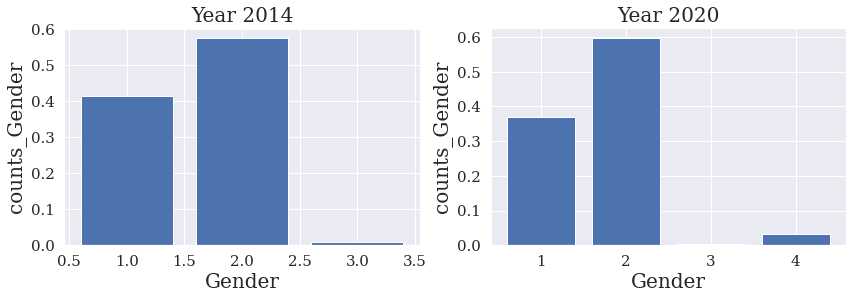

In [25]:
## plot gender
barCompare(d14["q1"], d20["q1"], xlab="Gender")

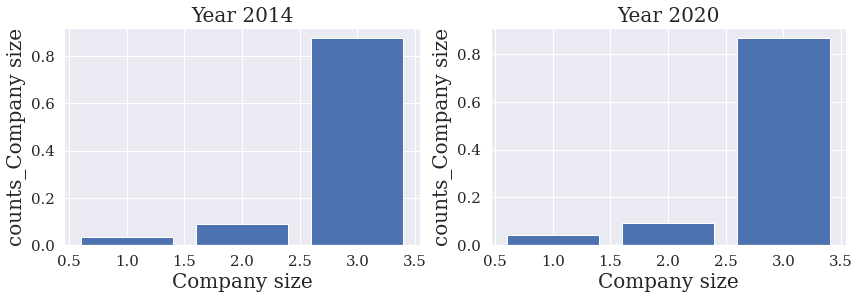

In [26]:
barCompare(d14["AS"], d20["AS"], xlab="Company size")

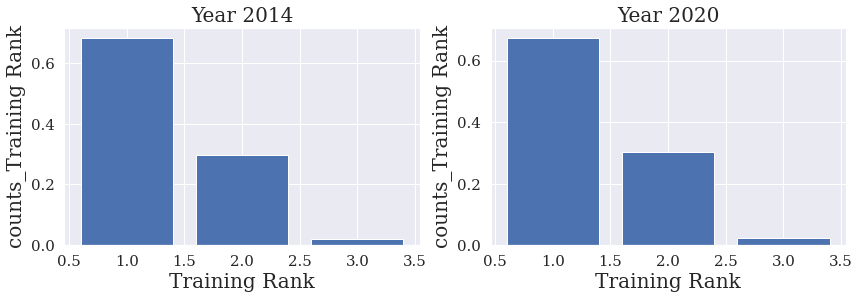

In [27]:
barCompare(d14["q6@"], d20["q5@"], xlab="Training Rank")

In [106]:
def uniquesByCol(x):
    """ Compute the unique values and counts
        from input array
    """
    
    v, c = np.unique(x, return_counts=True)
    return v, c

def proportionKey(ns):
    """ return the proper permutation ratio label as string """

    if ns == 0:
        return "0:1"
    elif ns == 1:
        return "1:0"
    # percentages of permutation mixing
    r1 = round(ns, 2)
    r2 = round(1-ns, 2)
    return str(r1)+":"+str(r2)

def PermuteBoostrap(X1, X2, Nboot=1000, Nsub=np.array([0,1]), Naccess=None, plot=False, title_=None, ylab=""):
    
    """
    Compute Bootstrap and Permutation from categorical data samples X1 and X2.
    
     distribtutions of X1 and X2 are unknown. In addition there is
     no guarantee that the samples are i.i.d. Where theThe idea is
     to provide support that the categorical distributions 
     (barplot) from two samples
    
    
    Parameters
    ----------
    X1 : array-like
        Categorical sample 1 to be Bootstrapped and Permuted
    X2 : array-like
        Categorical sample 2 to be Bootstrapped and Permuted
    Nboot : int, optional, default: 1000
        Number of Bootstrap iterations
    Nsub : 1D array-like, optional, default: np.array([0,1])
        Array of permutation percentages for X1, by default 
        the propotion for X2 will be extracted from Nsub, as
        (PS_X1:PS_X2)
    Naccess : optional
        number of data points accessible for bootstrap sampling
        if `None` the default is to take half of the shortest 
        length between X1 & X2
    plot : optional, default: False
        return plot of barplot heights as a function of permutation
        ratio (PS_X1:PS_X2) for the static X1 & X2 and boostrapped 
        + permuted percentage with 95% confidence intervals
    title_ : optional, defaul: None
        plot title
    ylab : optional, default: ""
        variable names for the categories, it needs to be in
        ascending order mathcing its corresponding integer label
    """
    
    # number of point accessibles for sampling
    if Naccess == None:
        nAccess = 0.5*min(X1.shape[0], X2.shape[0])
    else:
        nAccess = Naccess

    # Number of samples drawn for each Nsub (permutation ratio)
    Len14 = [int(round(nAccess * Nsub[i], 0)) for i in range(len(Nsub))]
    Len20 = [int(round(nAccess * (1-Nsub[i]), 0)) for i in range(len(Nsub))]
    
    ## initialize empty dicts to fill up
    Gender = {}
    CI = {}
    cnt = {}
    alpha = 0.05


    ## Bootsrap
    np.random.seed(42)
    for prop in range(len(Nsub)):
        
        # proportion key label: String
        pkey = proportionKey(Nsub[prop])
        
        # Confidence interval for 0.05 & 97.5 percentiles
        z = [st.norm.ppf(alpha/2, 0.0, 1.0),st.norm.ppf(1-alpha/2, 0.0, 1.0)]
        
        # Bootstrap and resample
        boot14_init = np.random.choice(X1, size=(Len14[prop], Nboot), replace=True)
        boot20_init = np.random.choice(X2, size=(Len20[prop], Nboot), replace=True)
        
        bootSamp_init = np.concatenate((boot14_init, boot20_init), axis=0)
        
        bootSamp = np.random.choice(np.ravel(bootSamp_init), replace=True, size=(50000, Nboot))
        Ns = bootSamp.shape[0]
        counts = []
        
        # compute unique value counts for boostrapped samples
        for j in range(Nboot):
            uni = uniquesByCol(bootSamp[:,j])
            counts.append(list(uni[1]))
        counts = np.array(counts)

        
        Counts = np.mean(counts, axis=0) 
        cnt[pkey] = counts
        Gender[pkey] = Counts/Ns

        ## Confidence intrvals for means of each category
        CI[pkey] = (Gender[pkey]+z[0]*Gender[pkey]/np.sqrt(Ns), Gender[pkey]+z[1]*Gender[pkey]/np.sqrt(Ns))
    
        # save results in variable
        Gkeys = list(Gender.keys())

    # plot
    if plot == True:
        # plot
        X1vals = X1.value_counts()/X1.shape[0]
        X2vals = X2.value_counts()/X2.shape[0]
        x = Nsub
        
        fig, axes = plt.subplots(3,1, figsize=(14,8))
        fig.subplots_adjust(hspace=0.05)
        
        axes[0].set_title(title_, size=20)
        for cat in range(len(Gender[Gkeys[0]])):
            try:
                y       = [Gender[kk][cat] for kk in Gkeys]
                yCIlow  = [CI[kk][0][cat] for kk in Gkeys]
                yCIhigh = [CI[kk][1][cat] for kk in Gkeys]
                
                axes[cat].fill_between(x, yCIlow, yCIhigh, alpha=0.5)
                axes[cat].plot(x, y, '.-', label="Boot")               
                
                
                axes[cat].set_ylabel("% "+ylab[cat])
            except:
                cat -= 1
                pass
        
        axes[0].plot(x, len(x)*[X1vals[1]], "--", label="2014")
        axes[0].plot(x, len(x)*[X2vals[1]], "--", label="2020")
        
        
        axes[1].plot(x, len(x)*[X1vals[2]], "--", label="2014")
        axes[1].plot(x, len(x)*[X2vals[2]], "--", label="2020")
        
        axes[2].plot(x, len(x)*[X1vals[3]], "--", label="2014")
        axes[2].plot(x, len(x)*[X2vals[3]], "--", label="2020")

        plt.legend()
        plt.xticks(x, Gkeys, rotation = 70)
        axes[cat].set_xlabel("Bootstrap Permutation Ratio [$PS_{2014}:PS_{2020}$]")
        plt.show() 
        #savePNG(title_)

    return Gender, CI, cnt, X2vals

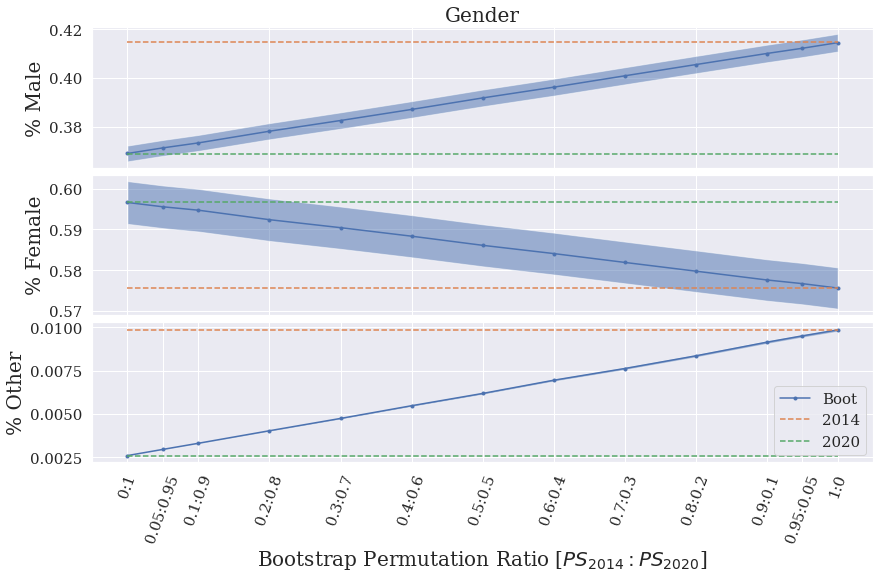

<Figure size 720x288 with 0 Axes>

In [107]:
# percentages of permutation samples
nsub = np.array([0, 0.05] + list(np.linspace(0.1, 0.9, 9)) + [0.95, 1])

# gender
gend = PermuteBoostrap(d14["q1"], d20["q1"], Nsub=nsub, title_="Gender", plot=True, ylab=["Male", "Female", "Other"])

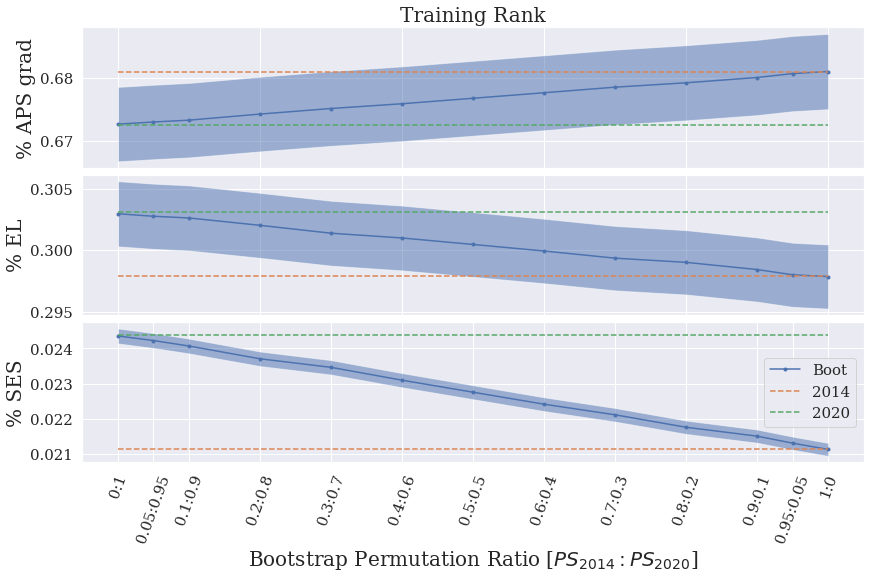

<Figure size 720x288 with 0 Axes>

In [108]:
aptrain = PermuteBoostrap(d14["q6@"], d20["q5@"], Nsub=nsub, title_="Training Rank", plot=True, ylab=["APS grad", "EL", "SES"])

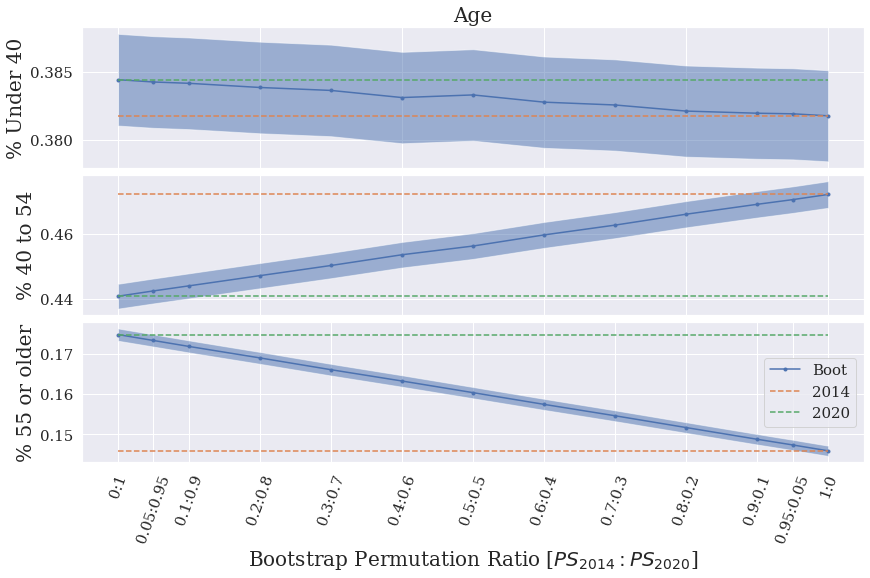

<Figure size 720x288 with 0 Axes>

In [109]:
age = PermuteBoostrap(d14["q2@"], d20["q2@"], Nsub=nsub, title_="Age", plot=True, ylab=["Under 40", "40 to 54", "55 or older"])

In general the dashed lines are not very distant from each other, so it is not trivial to distinguish if the distributions between 2014 and 2020 are equal. This is the reason with pulling up larger data from bootstrap is advantageous, because we can generate an empirical distribution of estimated percentages per category. Now, going back to the initial issue, if the blue curve includes both values for the raw percentages (dashed lines) as the Permutation Sample ratio varies, then we would be facing samples identically distributed. However, we can see this happening only for ages “under 40” (Middle figure) and “APS grad” (Bottom), but for every other category, there is a clear difference of the estimated percentage value for the two year samples. Moreover, as we sweep the Permutation ratio we can see the bootstrapped line monotonically shifting to the other extreme, thus meaning that there is a clear indication of different distributions.

Lastly, these tests provided good insight in rejecting that the two samples follow the same parent distribution. However, little we can tell of independence. Unfortunately there is no theory that has solved the independence problem, thus we are left with a qualitative analysis to address this. The nature of the data is within the realm of social studies, and the context of the census takers is within the same body, the Australian Public Service sector. So, it is likely that many of the people were the same in 2014 and 2020 and took the latter test with a mechanic strategy copying the answers of the first time they took it. Thus compromising the independence property.
